In [ ]:
import math
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from tqdm import trange
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_theme(style="whitegrid", context="talk")
sns.set_palette("Set2")

plt.rcParams.update({
    "figure.dpi": 110,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "bold",
    "axes.titlesize": 15,
    "axes.labelsize": 12,
    "legend.frameon": False,
    "legend.fontsize": 11,
})

print("BELIEF POLARIZATION UNDER MISINFORMATION")


GROUND_TRUTH = 0.75
ACCEPTANCE_THRESHOLD = 0.50

AGENT_TYPES = {
    "accepting": {
        "freq": 0.50,
        "belief_mean": 0.40,
        "belief_std": 0.35,
        "identity_mean": 0.65,
        "identity_std": 0.15
    },
    "hesitant": {
        "freq": 0.35,
        "belief_mean": -0.10,
        "belief_std": 0.40,
        "identity_mean": 0.74,
        "identity_std": 0.12
    },
    "resistant": {
        "freq": 0.15,
        "belief_mean": -0.70,
        "belief_std": 0.20,
        "identity_mean": 0.94,
        "identity_std": 0.04
    }
}

BASE_SOURCE_CONFIG = [
    ("scientific", 3, (0.88, 0.98), (-0.05, 0.05), 0.0),
    ("media",      5, (0.55, 0.75), (-0.25, 0.25), 0.12),
    ("social",     8, (0.30, 0.60), (-0.55, 0.55), 0.25),
]


BELIEF POLARIZATION UNDER MISINFORMATION


In [ ]:
class InformationSource:
    def __init__(self, tier, source_id, credibility, bias, misinfo_level=0.0):
        self.tier = tier
        self.id = source_id
        self.base_credibility = credibility
        self.bias = bias
        self.misinfo_level = misinfo_level

    def get_signal(self, ground_truth=GROUND_TRUTH):
        true_signal = ground_truth + self.bias
        true_signal += np.random.normal(0, 0.25)
        if np.random.rand() < self.misinfo_level:
            corrupted = -0.6 * ground_truth + np.random.normal(0, 0.35)
            signal = corrupted
        else:
            signal = true_signal
        return np.clip(signal, -1, 1)

    def get_effective_credibility(self):
        cred = self.base_credibility * (1.0 - 0.75 * self.misinfo_level)
        return np.clip(cred, 0.05, 1.0)


class InformationEcosystem:
    def __init__(self, scenario):
        self.scenario = scenario
        self.sources = []
        self._build_sources()
        self._apply_scenario()

    def _build_sources(self):
        idx = 0
        for tier, count, cred_range, bias_range, misinfo in BASE_SOURCE_CONFIG:
            for _ in range(count):
                cred = np.random.uniform(*cred_range)
                bias = np.random.uniform(*bias_range)
                self.sources.append(
                    InformationSource(tier, idx, cred, bias, misinfo_level=misinfo)
                )
                idx += 1

    def _apply_scenario(self):
        if self.scenario == "optimal":
            for s in self.sources:
                s.misinfo_level = 0.0
                s.base_credibility = 0.98
                s.bias = np.clip(s.bias, -0.05, 0.05)
        elif self.scenario == "realistic":
            for s in self.sources:
                if s.tier == "scientific":
                    s.misinfo_level = 0.02
                    s.base_credibility = max(s.base_credibility, 0.90)
                elif s.tier == "media":
                    s.misinfo_level = max(s.misinfo_level, 0.15)
                elif s.tier == "social":
                    s.misinfo_level = max(s.misinfo_level, 0.25)
        elif self.scenario == "misinformation":
            for s in self.sources:
                if s.tier == "scientific":
                    s.misinfo_level = 0.06
                    s.base_credibility = max(0.82, s.base_credibility - 0.08)
                elif s.tier == "media":
                    s.misinfo_level = min(1.0, s.misinfo_level + 0.22)
                    s.base_credibility = max(0.45, s.base_credibility - 0.10)
                elif s.tier == "social":
                    s.misinfo_level = min(1.0, s.misinfo_level + 0.30)
                    s.base_credibility = max(0.33, s.base_credibility - 0.07)

    def sample_signal_for_agent(self, tier_prefs):
        candidates = []
        weights = []
        for src in self.sources:
            tier_weight = tier_prefs.get(src.tier, 0.0)
            if tier_weight <= 0:
                continue
            eff_cred = src.get_effective_credibility()
            w = tier_weight * eff_cred
            if w > 0:
                candidates.append(src)
                weights.append(w)
        if not candidates:
            return np.random.uniform(-1, 1)
        weights = np.array(weights)
        weights = weights / weights.sum()
        chosen = np.random.choice(candidates, p=weights)
        return chosen.get_signal()


In [ ]:
class IdentityAgent:
    def __init__(self, agent_id, agent_type, params, tier_prefs):
        self.id = agent_id
        self.type = agent_type
        self.lambda_i = np.clip(np.random.normal(params["identity_mean"], params["identity_std"]), 0.0, 1.0)
        self.belief = np.clip(np.random.normal(params["belief_mean"], params["belief_std"]), -1.0, 1.0)
        self.tier_prefs = tier_prefs
        self.belief_history = [self.belief]
        self.lambda_history = [self.lambda_i]

    def accepts(self):
        return self.belief > ACCEPTANCE_THRESHOLD

    def update_belief(self, info_signal, neighbor_beliefs, w_s=0.45, w_n=0.55):
        if neighbor_beliefs:
            social_term = float(np.mean(neighbor_beliefs))
        else:
            social_term = self.belief
        combined = w_s * info_signal + w_n * social_term
        new_belief = self.lambda_i * self.belief + (1.0 - self.lambda_i) * combined
        self.belief = float(np.clip(new_belief, -1, 1))
        self.belief_history.append(self.belief)
        self.lambda_history.append(self.lambda_i)


In [ ]:
class IdentityBeliefSimulation:
    def __init__(self, n_agents=150, n_rounds=150, scenario="realistic",
                 homophily=0.65, seed=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        self.n_agents = n_agents
        self.n_rounds = n_rounds
        self.scenario = scenario
        self.homophily = homophily

        self.ecosystem = InformationEcosystem(scenario=scenario)
        self.agents = self._build_agents()
        self.network = self._build_network()

        self.acceptance_history = []
        self.accuracy_history = []
        self.polarization_history = []
        self.type_acceptance_history = []
        self.opinion_assortativity = None

    def _sample_agent_type(self):
        types = list(AGENT_TYPES.keys())
        freqs = np.array([AGENT_TYPES[t]["freq"] for t in types])
        freqs = freqs / freqs.sum()
        return np.random.choice(types, p=freqs)

    def _tier_prefs_for_type(self, agent_type):
        if agent_type == "accepting":
            return {"scientific": 0.55, "media": 0.30, "social": 0.15}
        elif agent_type == "hesitant":
            return {"scientific": 0.30, "media": 0.40, "social": 0.30}
        else:
            return {"scientific": 0.10, "media": 0.30, "social": 0.60}

    def _build_agents(self):
        agents = []
        for i in range(self.n_agents):
            a_type = self._sample_agent_type()
            params = AGENT_TYPES[a_type]
            prefs = self._tier_prefs_for_type(a_type)
            agents.append(IdentityAgent(i, a_type, params, prefs))
        return agents

    def _build_network(self, mean_degree=8):
        G = nx.Graph()
        G.add_nodes_from(range(self.n_agents))

        same_type_p = min(1.0, self.homophily * mean_degree / self.n_agents * 2)
        diff_type_p = (1.0 - self.homophily) * mean_degree / self.n_agents * 2

        for i in range(self.n_agents):
            for j in range(i + 1, self.n_agents):
                if self.agents[i].type == self.agents[j].type:
                    p = same_type_p
                else:
                    p = diff_type_p
                if np.random.rand() < p:
                    G.add_edge(i, j)

        for node in G.nodes():
            if G.degree[node] == 0 and self.n_agents > 1:
                partner = random.choice([x for x in G.nodes() if x != node])
                G.add_edge(node, partner)

        return G

    def _compute_metrics(self):
        beliefs = np.array([a.belief for a in self.agents])
        acceptance = np.mean(beliefs > ACCEPTANCE_THRESHOLD)
        accuracy = 1.0 - (np.abs(beliefs - GROUND_TRUTH).mean() / 2.0)
        polarization = np.mean(np.abs(beliefs - beliefs.mean()))
        self.acceptance_history.append(acceptance)
        self.accuracy_history.append(accuracy)
        self.polarization_history.append(polarization)
        type_counts = {t: 0 for t in AGENT_TYPES.keys()}
        type_accepts = {t: 0 for t in AGENT_TYPES.keys()}
        for a in self.agents:
            type_counts[a.type] += 1
            if a.accepts():
                type_accepts[a.type] += 1
        type_accept_rate = {
            t: (type_accepts[t] / type_counts[t] if type_counts[t] > 0 else np.nan)
            for t in AGENT_TYPES
        }
        self.type_acceptance_history.append(type_accept_rate)

    def _compute_opinion_assortativity(self):
        belief_labels = {}
        for a in self.agents:
            if a.belief > ACCEPTANCE_THRESHOLD:
                label = "pro"
            elif a.belief < 0:
                label = "anti"
            else:
                label = "mixed"
            belief_labels[a.id] = label
            self.network.nodes[a.id]["belief_label"] = label

        try:
            r = nx.attribute_assortativity_coefficient(self.network, "belief_label")
        except Exception:
            r = np.nan
        self.opinion_assortativity = r

    def run(self, verbose=True):
        iterator = trange(self.n_rounds, desc=self.scenario, leave=False) if verbose else range(self.n_rounds)
        for _ in iterator:
            self._compute_metrics()
            for agent in self.agents:
                signal = self.ecosystem.sample_signal_for_agent(agent.tier_prefs)
                neighbors = list(self.network.neighbors(agent.id))
                neigh_beliefs = [self.agents[n].belief for n in neighbors]
                agent.update_belief(signal, neigh_beliefs)
        self._compute_opinion_assortativity()

    def get_summary(self):
        final_beliefs = np.array([a.belief for a in self.agents])
        final_acceptance = np.mean(final_beliefs > ACCEPTANCE_THRESHOLD)
        final_accuracy = 1.0 - (np.abs(final_beliefs - GROUND_TRUTH).mean() / 2.0)
        final_polarization = np.mean(np.abs(final_beliefs - final_beliefs.mean()))
        return {
            "scenario": self.scenario,
            "final_acceptance": final_acceptance,
            "final_accuracy": final_accuracy,
            "final_polarization": final_polarization,
            "opinion_assortativity": self.opinion_assortativity,
        }


In [ ]:
#Visuals
def plot_time_series(simulations, scenario_labels):
    fig = plt.figure(figsize=(18, 8))
    gs = GridSpec(2, 3, figure=fig, height_ratios=[1.0, 1.0])

    axes = [
        fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[0, 2]),
        fig.add_subplot(gs[1, :])
    ]

    colors = ["#2E86AB", "#A23B72", "#F18F01"]
    type_names = list(AGENT_TYPES.keys())

    for sim, label, color in zip(simulations, scenario_labels, colors):
        t = np.arange(len(sim.acceptance_history))
        axes[0].plot(t, sim.acceptance_history, label=label, color=color, linewidth=2)
        axes[1].plot(t, sim.accuracy_history, label=label, color=color, linewidth=2)
        axes[2].plot(t, sim.polarization_history, label=label, color=color, linewidth=2)

    for sim, label, color in zip(simulations, scenario_labels, colors):
        type_accept = {t: [] for t in type_names}
        for record in sim.type_acceptance_history:
            for t_name in type_names:
                type_accept[t_name].append(record[t_name])
        for t_idx, t_name in enumerate(type_names):
            axes[3].plot(
                type_accept[t_name],
                label=f"{label} – {t_name}",
                color=color,
                linestyle=["-", "--", ":"][t_idx],
                linewidth=2
            )

    axes[0].set_title("Acceptance over time")
    axes[1].set_title("Accuracy over time")
    axes[2].set_title("Polarization over time")
    axes[3].set_title("Per-type acceptance over time")

    for ax in axes[:3]:
        ax.set_xlabel("Round")
        ax.grid(alpha=0.3)
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.0%}"))
    axes[2].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    axes[0].set_ylabel("Acceptance")
    axes[1].set_ylabel("Accuracy")
    axes[2].set_ylabel("Polarization")
    axes[3].set_ylabel("Acceptance")
    axes[3].set_xlabel("Round")

    for ax in axes:
        ax.legend(ncol=2)

    fig.suptitle("Identity-based belief dynamics across scenarios", fontsize=16, fontweight="bold")
    fig.tight_layout(rect=[0, 0.02, 1, 0.97])
    plt.show()


def plot_final_distributions(simulations, scenario_labels):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    colors = ["#2E86AB", "#A23B72", "#F18F01"]

    for sim, label, color in zip(simulations, scenario_labels, colors):
        final_beliefs = [a.belief for a in sim.agents]
        sns.kdeplot(final_beliefs, label=label, color=color, ax=axes[0], fill=True, alpha=0.25)

    axes[0].axvline(ACCEPTANCE_THRESHOLD, color="black", linestyle="--", alpha=0.6,
                    label="Acceptance threshold")
    axes[0].set_title("Final belief distributions")
    axes[0].set_xlabel("Belief")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    real_sim = [s for s in simulations if s.scenario == "realistic"][0]
    data = [{"type": a.type, "belief": a.belief} for a in real_sim.agents]
    df = pd.DataFrame(data)
    sns.violinplot(data=df, x="type", y="belief", ax=axes[1], palette="Set2",
                   cut=0, inner="box")
    axes[1].axhline(ACCEPTANCE_THRESHOLD, color="black", linestyle="--", alpha=0.5)
    axes[1].set_title("Final beliefs by archetype (realistic scenario)")
    axes[1].set_xlabel("Archetype")
    axes[1].set_ylabel("Belief")

    fig.suptitle("End-state belief structure", fontsize=16, fontweight="bold")
    fig.tight_layout(rect=[0, 0.02, 1, 0.97])
    plt.show()


def _belief_cluster_label(belief):
    if belief > ACCEPTANCE_THRESHOLD:
        return "pro"
    elif belief < 0:
        return "anti"
    else:
        return "mixed"


def plot_network(simulation, title_suffix=""):
    fig, ax = plt.subplots(figsize=(7, 6))
    pos = nx.spring_layout(simulation.network, seed=42, k=0.6)
    final_beliefs = np.array([a.belief for a in simulation.agents])

    type_to_color = {"accepting": "#2E86AB", "hesitant": "#A23B72", "resistant": "#F18F01"}
    node_colors = []
    edge_colors = []

    for node in simulation.network.nodes():
        a = simulation.agents[node]
        node_colors.append(final_beliefs[node])
        edge_colors.append(type_to_color[a.type])

    nx.draw_networkx_nodes(
        simulation.network, pos,
        node_color=node_colors,
        cmap="RdYlGn",
        vmin=-1, vmax=1,
        node_size=60,
        linewidths=0.8,
        edgecolors=edge_colors,
        alpha=0.9,
        ax=ax
    )
    nx.draw_networkx_edges(simulation.network, pos, alpha=0.15, width=0.4, ax=ax)
    ax.set_title(f"Social network – final beliefs {title_suffix}")
    ax.axis("off")

    sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=plt.Normalize(vmin=-1, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Final belief")

    plt.tight_layout()
    plt.show()

    components = list(nx.connected_components(simulation.network))
    cluster_labels = []
    for comp in components:
        beliefs_comp = [simulation.agents[i].belief for i in comp]
        avg_b = np.mean(beliefs_comp)
        cluster_labels.append(_belief_cluster_label(avg_b))
    counts = pd.Series(cluster_labels).value_counts()
    print(f"Cluster composition {title_suffix}:")
    print(counts.to_string(), "\n")

In [ ]:
def one_factor_sensitivity(param_name, values, scenario="realistic",
                           n_agents=150, n_rounds=200, reps=30):
    results = []
    for v in values:
        accs = []
        for rep in range(reps):
            seed = 1000 + rep
            if param_name == "identity_hesitant":
                AGENT_TYPES["hesitant"]["identity_mean"] = v
            elif param_name == "homophily":
                hom = v
            elif param_name == "social_misinfo_realistic":
                pass

            sim = IdentityBeliefSimulation(
                n_agents=n_agents,
                n_rounds=n_rounds,
                scenario=scenario,
                homophily=(v if param_name == "homophily" else 0.65),
                seed=seed
            )
            sim.run(verbose=False)
            s = sim.get_summary()
            accs.append(s["final_acceptance"])
        results.append(np.mean(accs))

    return np.array(values), np.array(results)


def plot_one_factor_sensitivity():
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    vals = np.linspace(0.6, 0.85, 6)
    x, y = one_factor_sensitivity("identity_hesitant", vals, scenario="realistic")
    ax.plot(x, y, marker="o", linewidth=2)
    ax.set_title("Sensitivity: hesitant identity vs acceptance (realistic)")
    ax.set_xlabel("Hesitant identity mean (lambda)")
    ax.set_ylabel("Final acceptance")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda v, _: f"{v:.0%}"))
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def heatmap_sensitivity_identity_vs_homophily():
    id_vals = np.linspace(0.65, 0.80, 5)
    hom_vals = np.linspace(0.5, 0.8, 5)
    mean_acc = np.zeros((len(id_vals), len(hom_vals)))

    for i, id_v in enumerate(id_vals):
        AGENT_TYPES["hesitant"]["identity_mean"] = id_v
        for j, h_v in enumerate(hom_vals):
            accs = []
            for rep in range(15):
                sim = IdentityBeliefSimulation(
                    n_agents=150,
                    n_rounds=200,
                    scenario="realistic",
                    homophily=h_v,
                    seed=5000 + rep
                )
                sim.run(verbose=False)
                s = sim.get_summary()
                accs.append(s["final_acceptance"])
            mean_acc[i, j] = np.mean(accs)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(
        mean_acc,
        xticklabels=[f"{v:.2f}" for v in hom_vals],
        yticklabels=[f"{v:.2f}" for v in id_vals],
        cmap="viridis",
        annot=True,
        fmt=".2f",
        ax=ax
    )
    ax.set_title("Sensitivity heatmap: hesitant identity vs homophily\n(final acceptance, realistic)")
    ax.set_xlabel("Homophily")
    ax.set_ylabel("Hesitant identity mean")
    plt.tight_layout()
    plt.show()


In [ ]:
def out_of_sample_check(param_set, era_A_target=0.66, era_B_target=0.60):
    AGENT_TYPES["hesitant"]["identity_mean"] = param_set.get("id_hes", AGENT_TYPES["hesitant"]["identity_mean"])
    AGENT_TYPES["resistant"]["identity_mean"] = param_set.get("id_res", AGENT_TYPES["resistant"]["identity_mean"])

    accs_A = []
    for seed in range(30):
        sim = IdentityBeliefSimulation(
            n_agents=150,
            n_rounds=200,
            scenario="realistic",
            homophily=0.65,
            seed=9000 + seed
        )
        sim.run(verbose=False)
        accs_A.append(sim.get_summary()["final_acceptance"])
    mean_A = np.mean(accs_A)


    accs_B = []
    for seed in range(30):
        sim = IdentityBeliefSimulation(
            n_agents=150,
            n_rounds=200,
            scenario="misinformation",
            homophily=0.65,
            seed=10000 + seed
        )
        sim.run(verbose=False)
        accs_B.append(sim.get_summary()["final_acceptance"])
    mean_B = np.mean(accs_B)

    print("Out-of-sample style check:")
    print(f"  Era A (realistic-like) mean: {mean_A:.1%}")
    print(f"  Era B (misinfo-like)   mean: {mean_B:.1%}")


RUNNING SCENARIOS

SCENARIO: OPTIMAL – Optimal



✓ Optimal Results:
  Mean acceptance: 96.9%
  95% CI: [93.3%, 99.3%]
  Std dev: 1.82%
  Mean opinion assortativity (pro/anti/mixed): 0.024

SCENARIO: REALISTIC – Realistic



✓ Realistic Results:
  Mean acceptance: 69.0%
  95% CI: [41.9%, 86.0%]
  Std dev: 11.64%
  Mean opinion assortativity (pro/anti/mixed): 0.052

SCENARIO: MISINFORMATION – Misinformation



✓ Misinformation Results:
  Mean acceptance: 22.4%
  95% CI: [9.3%, 34.8%]
  Std dev: 6.68%
  Mean opinion assortativity (pro/anti/mixed): 0.046


FINAL RESULTS COMPARISON
      Scenario  MeanAcceptance   CI_low  CI_high      Std  OpinionAssortativity
       Optimal        0.969333 0.933167 0.993500 0.018176              0.023984
     Realistic        0.690333 0.419167 0.860000 0.116450              0.051647
Misinformation        0.224000 0.092833 0.347667 0.066790              0.046392


Realistic scenario mean acceptance: 69.0% Absolute error: 3.0 percentage points

Generating time-series panel...


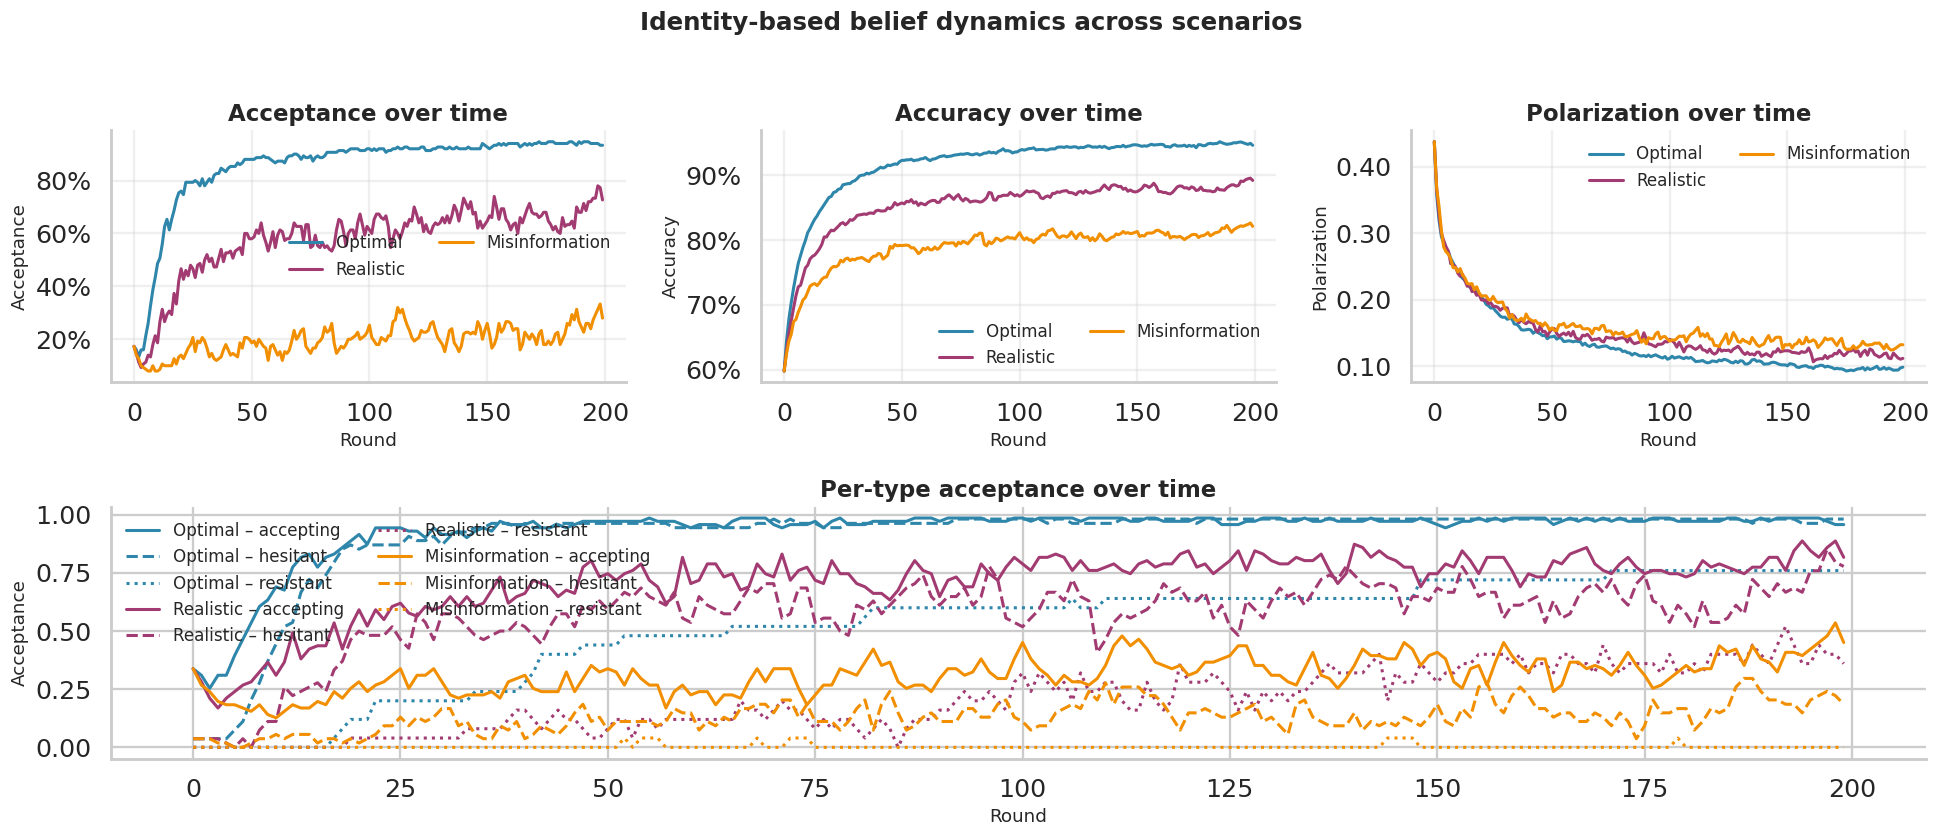

Generating final-state distributions & archetype violin...


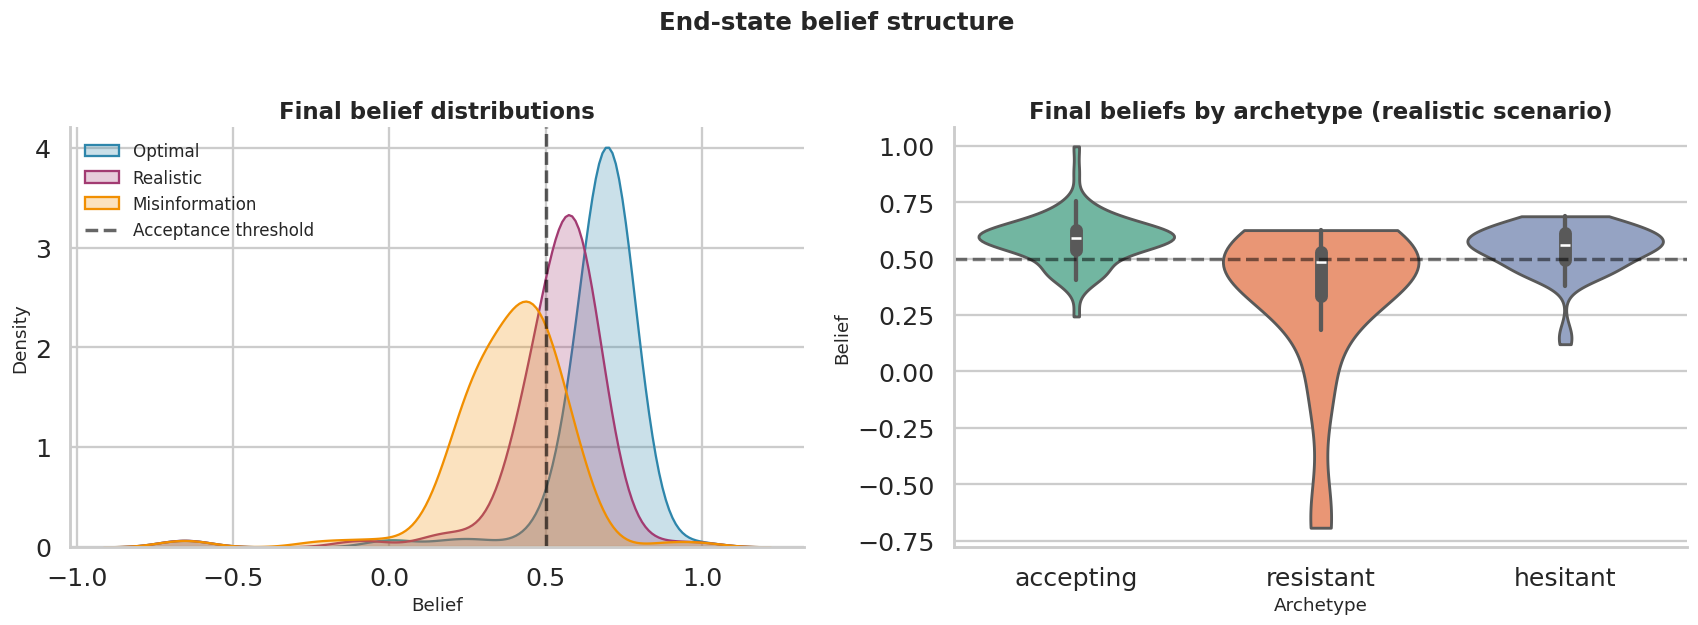

Generating network visuals and cluster diagnostics for each scenario...


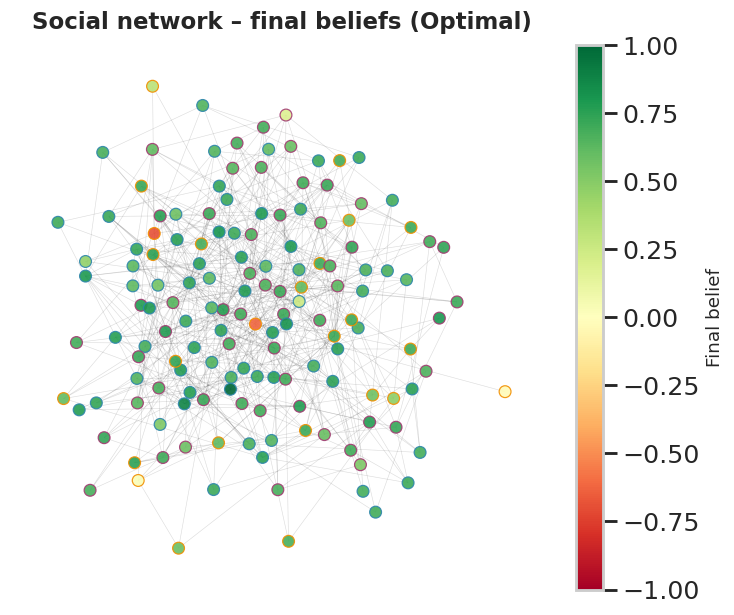

Cluster composition (Optimal):
pro    1 



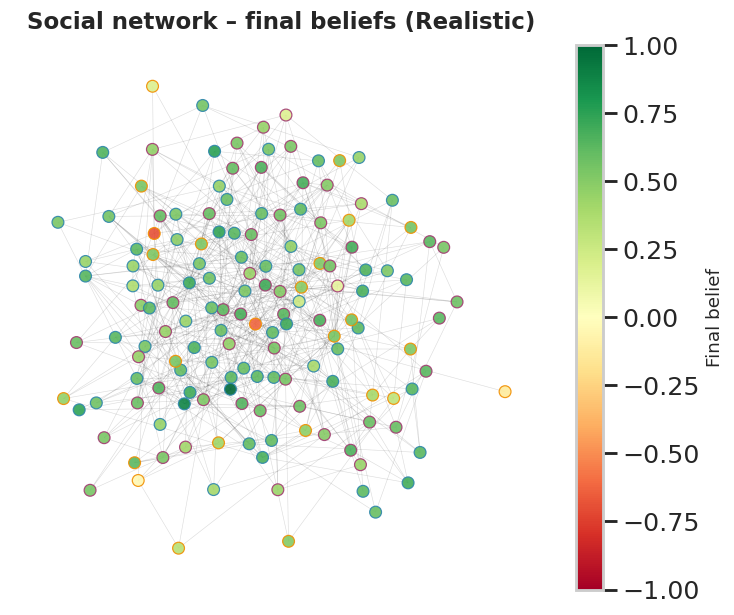

Cluster composition (Realistic):
pro    1 



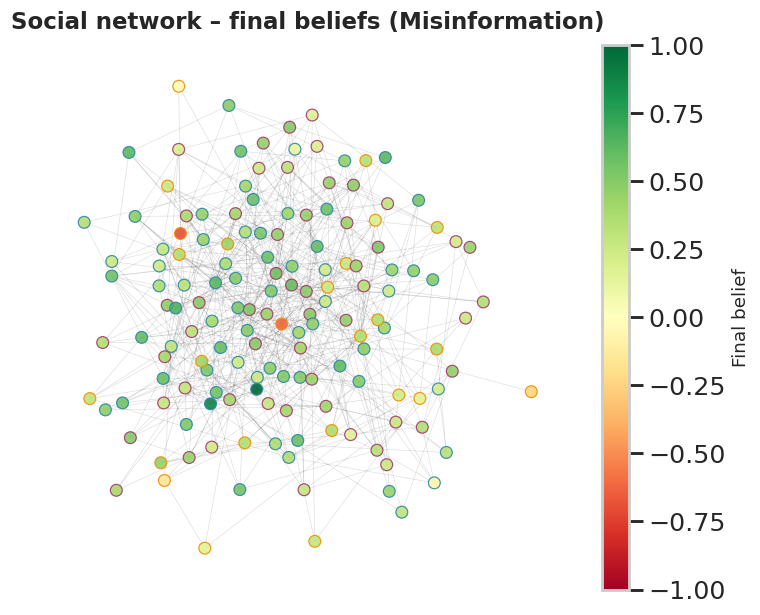

Cluster composition (Misinformation):
mixed    1 

Running one-factor sensitivity example...


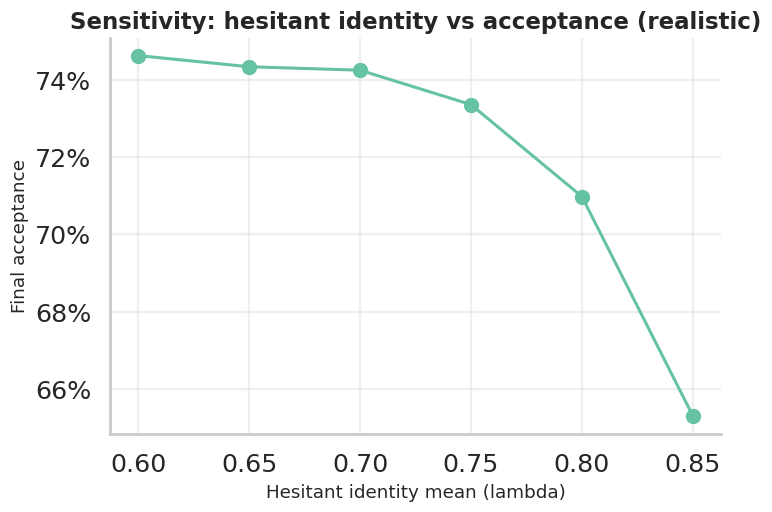

Running 2D heatmap sensitivity (identity vs homophily)...


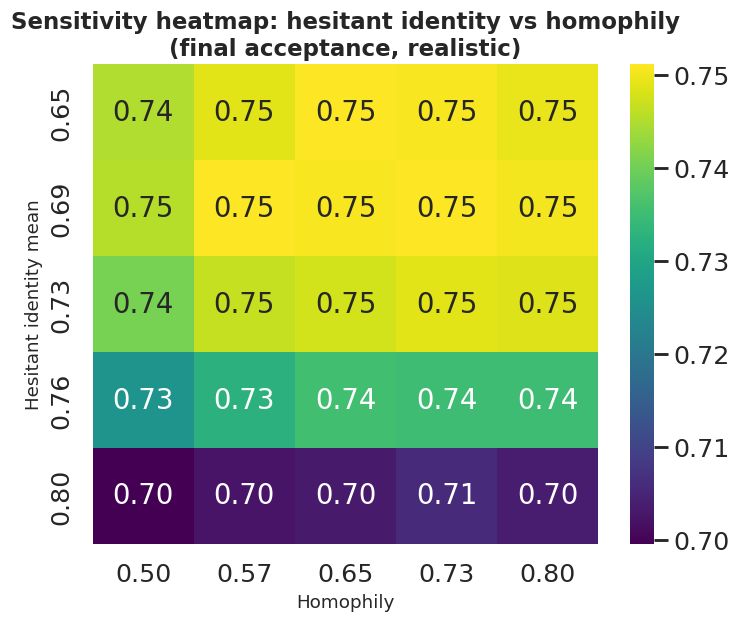

Running simple out-of-sample style check...
Out-of-sample style check:
  Era A (realistic-like) mean: 68.6%
  Era B (misinfo-like)   mean: 16.8%


In [ ]:
def run_experiment(n_agents=150, n_rounds=200, n_rep=80, verbose=True):
    scenarios = [
        ("optimal", "Optimal"),
        ("realistic", "Realistic"),
        ("misinformation", "Misinformation")
    ]

    all_results = []
    example_sims = []

    print("\n" + "=" * 100)
    print("RUNNING SCENARIOS")
    print("=" * 100 + "\n")

    for scenario_name, label in scenarios:
        print("=" * 100)
        print(f"SCENARIO: {scenario_name.upper()} – {label}")
        print("=" * 100 + "\n")

        scenario_summaries = []
        iterator = trange(n_rep, desc=scenario_name, leave=False) if verbose else range(n_rep)

        for rep in iterator:
            seed = 42 + rep
            sim = IdentityBeliefSimulation(
                n_agents=n_agents,
                n_rounds=n_rounds,
                scenario=scenario_name,
                homophily=0.65,
                seed=seed
            )
            sim.run(verbose=False)
            summary = sim.get_summary()
            scenario_summaries.append(summary)

        df = pd.DataFrame(scenario_summaries)
        mean_acc = df["final_acceptance"].mean()
        std_acc = df["final_acceptance"].std()
        ci_low, ci_high = np.percentile(df["final_acceptance"], [2.5, 97.5])
        mean_assort = df["opinion_assortativity"].mean()

        all_results.append({
            "Scenario": label,
            "MeanAcceptance": mean_acc,
            "CI_low": ci_low,
            "CI_high": ci_high,
            "Std": std_acc,
            "OpinionAssortativity": mean_assort
        })

        sim = IdentityBeliefSimulation(
            n_agents=n_agents,
            n_rounds=n_rounds,
            scenario=scenario_name,
            homophily=0.65,
            seed=123
        )
        sim.run(verbose=False)
        example_sims.append(sim)

        print(f"✓ {label} Results:")
        print(f"  Mean acceptance: {mean_acc:.1%}")
        print(f"  95% CI: [{ci_low:.1%}, {ci_high:.1%}]")
        print(f"  Std dev: {std_acc:.2%}")
        print(f"  Mean opinion assortativity (pro/anti/mixed): {mean_assort:.3f}\n")

    results_df = pd.DataFrame(all_results)
    print("\n" + "=" * 100)
    print("FINAL RESULTS COMPARISON")
    print("=" * 100)
    print(results_df.to_string(index=False))

    REAL_ACCEPT = 0.66
    realistic_row = results_df[results_df["Scenario"] == "Realistic"].iloc[0]
    err_pp = abs(realistic_row["MeanAcceptance"] - REAL_ACCEPT) * 100
    print("\n")
    print(
        f"Realistic scenario mean acceptance: {realistic_row['MeanAcceptance']:.1%} "
        f"Absolute error: {err_pp:.1f} percentage points\n"
    )

    scenario_labels = [s[1] for s in scenarios]

    print("Generating time-series panel...")
    plot_time_series(example_sims, scenario_labels)

    print("Generating final-state distributions & archetype violin...")
    plot_final_distributions(example_sims, scenario_labels)

    print("Generating network visuals and cluster diagnostics for each scenario...")
    for sim, label in zip(example_sims, scenario_labels):
        plot_network(sim, title_suffix=f"({label})")

    print("Running one-factor sensitivity example...")
    plot_one_factor_sensitivity()

    print("Running 2D heatmap sensitivity (identity vs homophily)...")
    heatmap_sensitivity_identity_vs_homophily()

    print("Running simple out-of-sample style check...")
    out_of_sample_check(param_set={"id_hes": AGENT_TYPES["hesitant"]["identity_mean"],
                                   "id_res": AGENT_TYPES["resistant"]["identity_mean"]},
                        era_A_target=0.66, era_B_target=0.50)


def main():
    run_experiment(n_agents=150, n_rounds=200, n_rep=80, verbose=True)


if __name__ == "__main__":
    main()